# 5. Predictive Modeling and Evaluation

**Author:** Carlos Gómez Gómez

## Objective
In this final notebook, we use the cleaned and enriched dataset to train, evaluate, and compare several regression models. The goal is to select the best-performing model for predicting property prices in Barcelona.

The process includes:
1.  **Data Preparation:** Load the final dataset and split it into training and testing sets.
2.  **Model Training Pipeline:** Create a reusable function to handle hyperparameter tuning (`GridSearchCV`), model saving, and evaluation for any given algorithm.
3.  **Comparative Evaluation:** Train multiple models (from simple linear models to complex ensembles) and compare their performance using key metrics like R² and Mean Absolute Error (MAE).
4.  **Conclusion:** Select the best model to be used in our final application.

In [6]:
# --- 1. Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # Changed from joblib
import os
import math

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Model imports
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Set plot style and ignore warnings
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')

## 2. Data Preparation

We load the `barcelona_properties_clustered.csv` dataset prepared in the previous notebook. Then, we separate our features (X) from the target variable (y) and split the data into training and testing sets.

In [8]:
# --- Load Data ---
try:
    df = pd.read_csv('../data/barcelona_properties_clustered.csv')
    print("Clustered data loaded successfully.")
except FileNotFoundError:
    print("Error: 'barcelona_properties_clustered.csv' not found. Please run the previous notebooks first.")

# --- Prepare Features (X) and Target (y) ---
X = df.select_dtypes(include=np.number).drop(columns=['id', 'price', 'original_price', 'price_m2'])
y = df['price']

# --- Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Create models directory ---
if not os.path.exists('../models'):
    os.makedirs('../models')
    print("Created 'models' directory.")

# Save the scaler for later use in the app using pickle
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to ../models/scaler.pkl")

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Clustered data loaded successfully.
Scaler saved to ../models/scaler.pkl
Training set shape: (8855, 16)
Testing set shape: (2952, 16)


## 3. Phase 1: Model Training

The `train_and_save_models` function now saves the best model from `GridSearchCV` as a `.pkl` file.

In [13]:
def train_and_save_models(models_dict, params_dict, X_train, y_train):
    """
    Iterates through models, performs GridSearchCV, and saves the best estimator using pickle.
    """
    print("--- Starting Model Training Phase ---")
    for name, model in models_dict.items():
        print(f"Training {name}...")
        
        grid_search = GridSearchCV(estimator=model, param_grid=params_dict[name], 
                                   cv=5, n_jobs=-1, scoring='r2')
        
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        
        model_path = f'../models/{name}.pkl' # Changed extension to .pkl
        with open(model_path, 'wb') as f:
            pickle.dump(best_model, f) # Use pickle.dump
        
        print(f"Best {name} model saved to {model_path} with params: {grid_search.best_params_}")
    print("\n--- Model Training Phase Complete ---")

# --- Define Models and Hyperparameter Grids ---
# (This part remains the same)
models_to_train = {
    'Lasso': Lasso(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'MLPRegressor': MLPRegressor(random_state=42, max_iter=1000)
}

params_grid = {
    'Lasso': {'alpha': [0.1, 1.0, 10]},
    'DecisionTree': {'max_depth': [10, 20, None], 'min_samples_leaf': [1, 5]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'MLPRegressor': {'hidden_layer_sizes': [(50,50), (100,)], 'activation': ['relu', 'tanh']}
}

# --- Execute Training ---
train_and_save_models(models_to_train, params_grid, X_train, y_train)

--- Starting Model Training Phase ---
Training Lasso...
Best Lasso model saved to ../models/Lasso.pkl with params: {'alpha': 10}
Training DecisionTree...
Best DecisionTree model saved to ../models/DecisionTree.pkl with params: {'max_depth': 10, 'min_samples_leaf': 5}
Training RandomForest...
Best RandomForest model saved to ../models/RandomForest.pkl with params: {'max_depth': 20, 'n_estimators': 200}
Training GradientBoosting...
Best GradientBoosting model saved to ../models/GradientBoosting.pkl with params: {'learning_rate': 0.05, 'n_estimators': 200}
Training XGBoost...
Best XGBoost model saved to ../models/XGBoost.pkl with params: {'learning_rate': 0.05, 'n_estimators': 100}
Training MLPRegressor...
Best MLPRegressor model saved to ../models/MLPRegressor.pkl with params: {'activation': 'relu', 'hidden_layer_sizes': (50, 50)}

--- Model Training Phase Complete ---


## 4. Phase 2: Model Loading and Evaluation

The `load_and_evaluate_models` function now loads the `.pkl` files to evaluate the models.


--- Starting Model Evaluation Phase ---
Evaluating Lasso...


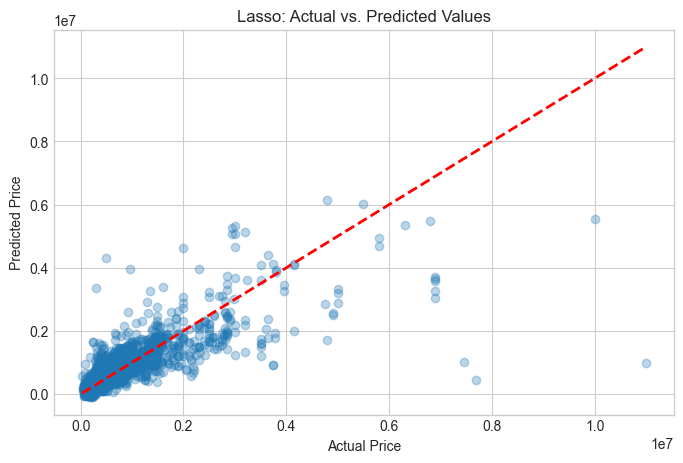

Evaluating DecisionTree...


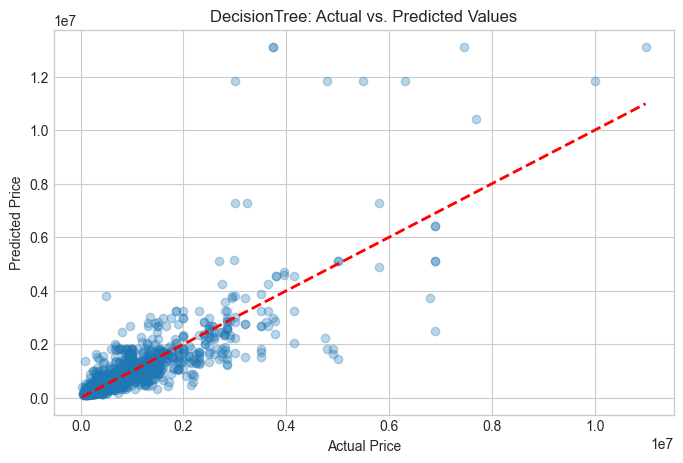

Evaluating RandomForest...


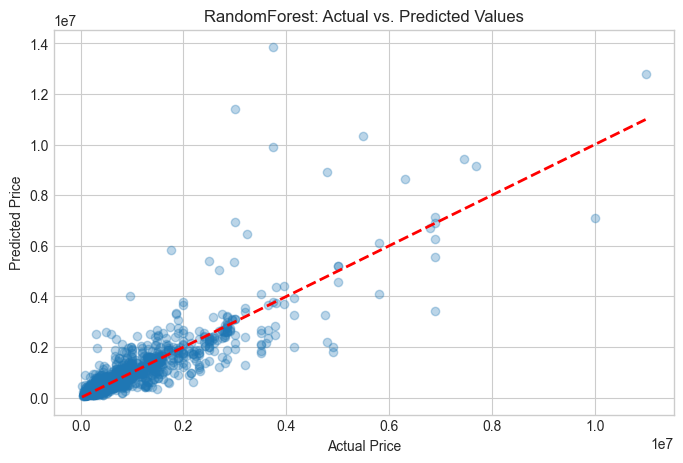

Evaluating GradientBoosting...


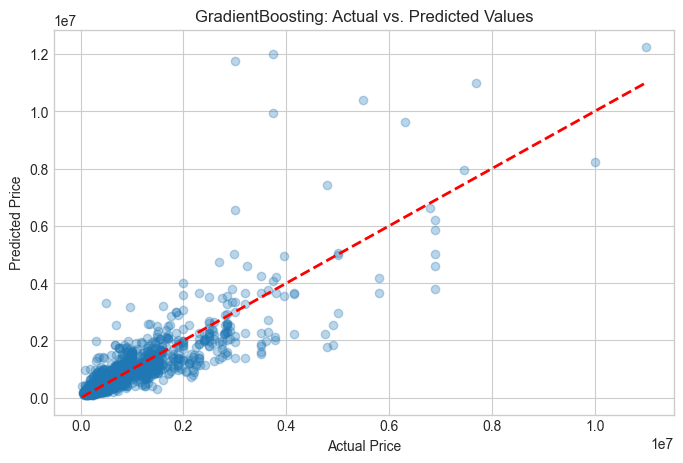

Evaluating XGBoost...


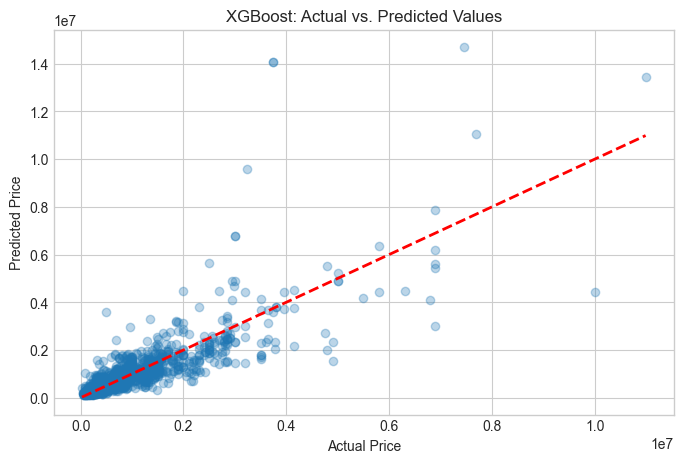

Evaluating MLPRegressor...


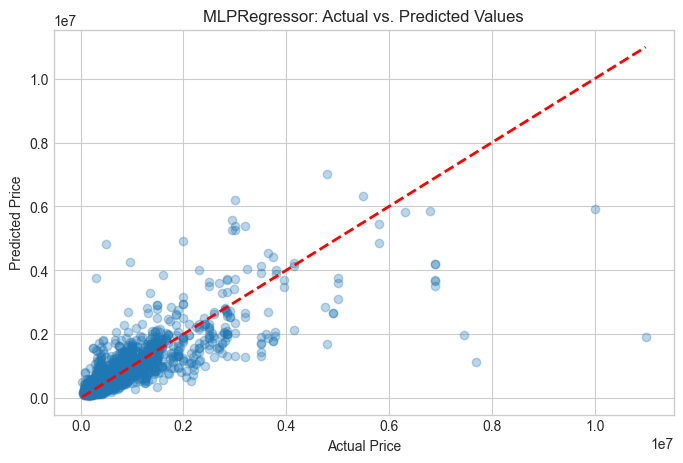


--- Model Evaluation Phase Complete ---


In [14]:
def load_and_evaluate_models(model_names, X_test, y_test):
    """
    Loads saved .pkl models, evaluates them, and returns performance metrics.
    """
    print("\n--- Starting Model Evaluation Phase ---")
    evaluation_results = []

    for name in model_names:
        print(f"Evaluating {name}...")
        model_path = f'../models/{name}.pkl' # Changed extension to .pkl
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f) # Use pickle.load
        except FileNotFoundError:
            print(f"Model {name} not found at {model_path}. Skipping.")
            continue
            
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = math.sqrt(mse)
        
        evaluation_results.append({ 'Model': name, 'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse })
        
        # Plot predictions vs actuals
        plt.figure(figsize=(8, 5))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
        plt.title(f'{name}: Actual vs. Predicted Values')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.show()

    print("\n--- Model Evaluation Phase Complete ---")
    return pd.DataFrame(evaluation_results)

# --- Execute Evaluation ---
model_names_to_evaluate = models_to_train.keys()
results_df = load_and_evaluate_models(model_names_to_evaluate, X_test, y_test)

## 5. Results and Conclusion

Let's display the final performance table to compare all models side-by-side.

In [15]:
# --- Compare Model Results ---
final_results = results_df.sort_values(by='R2', ascending=False).set_index('Model')
print("--- Final Model Performance Comparison ---")
final_results

--- Final Model Performance Comparison ---


,R2,MAE,MSE,RMSE
Model,,,,
GradientBoosting,0.685897,192270.037746,1.964868e+11,443268.357198
RandomForest,0.679477,162313.657707,2.005027e+11,447775.316945
MLPRegressor,0.645142,224737.128386,2.219809e+11,471148.458741
Lasso,0.617419,235828.506964,2.393231e+11,489206.617609
XGBoost,0.615294,190198.574685,2.406523e+11,490563.297055
DecisionTree,0.559756,198295.350823,2.753940e+11,524779.980547


## 6. Re-evaluation After Removing Outliers

Outliers can significantly skew the training process of some models. By removing them, we can often build a model that is more accurate for the majority of common properties. Here, we will filter out properties with prices that are statistical outliers and retrain our models on this cleaner dataset.

In [ ]:
# --- 6.1. Remove Outliers using the IQR Method on 'price' ---

print(f"Original dataset size: {df.shape[0]} properties")

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Filtered dataset size: {df_filtered.shape[0]} properties")
print(f"Removed {df.shape[0] - df_filtered.shape[0]} outliers.")

Original dataset size: 11807 properties
Filtered dataset size: 10932 properties
Removed 875 outliers.


### 6.2. Prepare and Retrain on Filtered Data

Now we repeat the exact same preparation, training, and evaluation process on the new `df_filtered` DataFrame.

In [17]:
# --- Prepare Filtered Features (X) and Target (y) ---
X_filtered = df_filtered.select_dtypes(include=np.number).drop(columns=['id', 'price', 'original_price', 'price_m2'])
y_filtered = df_filtered['price']

# --- Scale the new filtered data ---
# Important: We fit a NEW scaler on the filtered data
scaler_no_outliers = StandardScaler()
X_filtered_scaled = scaler_no_outliers.fit_transform(X_filtered)

# Save the new scaler
with open('../models/scaler_no_outliers.pkl', 'wb') as f:
    pickle.dump(scaler_no_outliers, f)
print("Scaler for filtered data saved.")

# --- Split the filtered data ---
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filtered_scaled, y_filtered, test_size=0.25, random_state=42)

# --- Retrain all models on the filtered data ---
# We will reuse our `train_and_save_models` function, but we need to modify it slightly
# to save the new models with a different name. Let's update our functions.

def train_and_save_models_v2(models_dict, params_dict, X_train, y_train, suffix=""):
    """
    Slightly modified function to add a suffix to the saved model filename.
    """
    print(f"--- Starting Model Training Phase ({suffix}) ---")
    for name, model in models_dict.items():
        print(f"Training {name}{suffix}...")
        grid_search = GridSearchCV(estimator=model, param_grid=params_dict[name], cv=5, n_jobs=-1, scoring='r2')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        model_path = f'../models/{name}{suffix}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(best_model, f)
        print(f"Best {name}{suffix} model saved to {model_path}")
    print("\n--- Model Training Phase Complete ---")

# Execute training for the filtered dataset
train_and_save_models_v2(models_to_train, params_grid, X_train_filt, y_train_filt, suffix="_no_outliers")

Scaler for filtered data saved.
--- Starting Model Training Phase (_no_outliers) ---
Training Lasso_no_outliers...
Best Lasso_no_outliers model saved to ../models/Lasso_no_outliers.pkl
Training DecisionTree_no_outliers...
Best DecisionTree_no_outliers model saved to ../models/DecisionTree_no_outliers.pkl
Training RandomForest_no_outliers...
Best RandomForest_no_outliers model saved to ../models/RandomForest_no_outliers.pkl
Training GradientBoosting_no_outliers...
Best GradientBoosting_no_outliers model saved to ../models/GradientBoosting_no_outliers.pkl
Training XGBoost_no_outliers...
Best XGBoost_no_outliers model saved to ../models/XGBoost_no_outliers.pkl
Training MLPRegressor_no_outliers...
Best MLPRegressor_no_outliers model saved to ../models/MLPRegressor_no_outliers.pkl

--- Model Training Phase Complete ---


### 6.3. Evaluate Models Trained on Filtered Data


--- Starting Model Evaluation Phase ---
Evaluating Lasso_no_outliers...


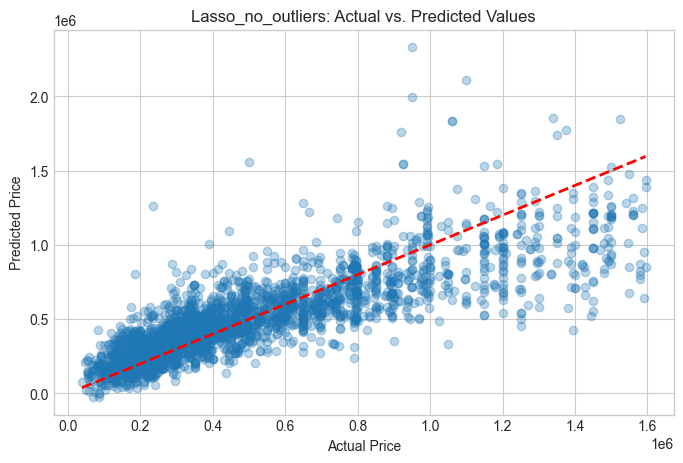

Evaluating DecisionTree_no_outliers...


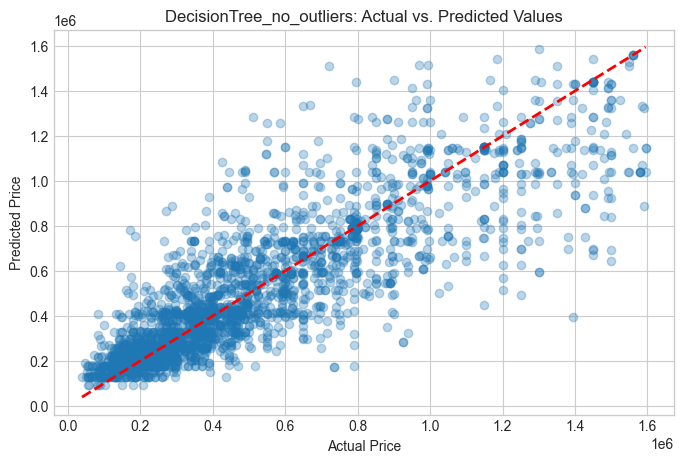

Evaluating RandomForest_no_outliers...


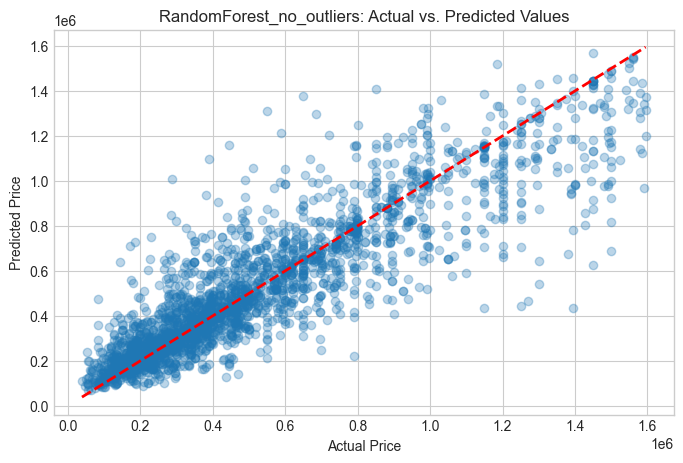

Evaluating GradientBoosting_no_outliers...


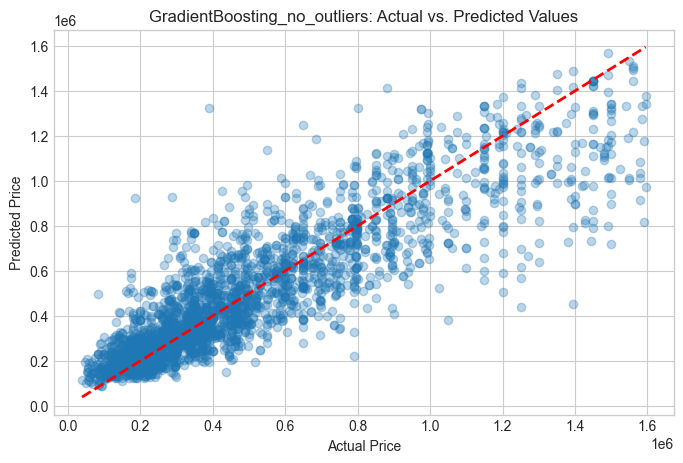

Evaluating XGBoost_no_outliers...


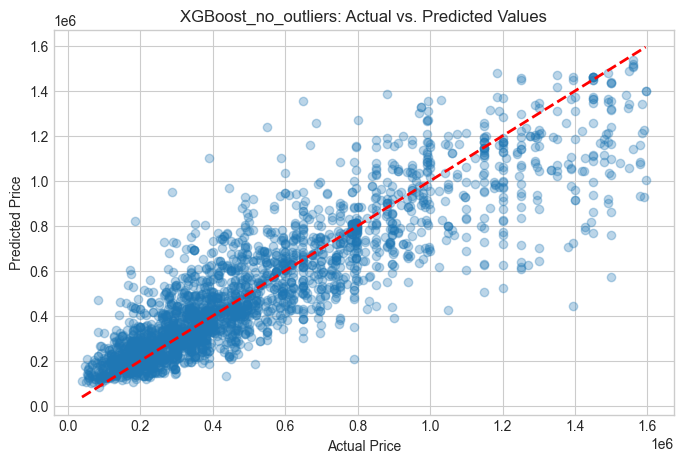

Evaluating MLPRegressor_no_outliers...


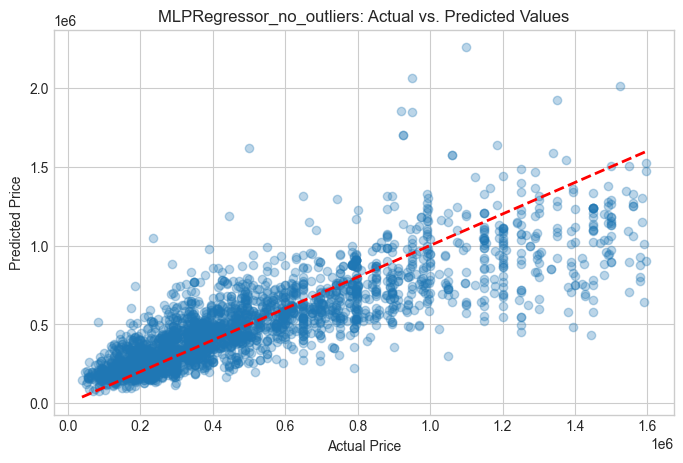


--- Model Evaluation Phase Complete ---
--- Final Model Performance Comparison (Without Outliers) ---


,R2,MAE,MSE,RMSE
Model,,,,
RandomForest_no_outliers,0.800545,97083.768185,2.345158e+10,153139.073417
XGBoost_no_outliers,0.787775,108853.922801,2.495305e+10,157965.331535
GradientBoosting_no_outliers,0.772260,113961.844161,2.677736e+10,163637.887815
DecisionTree_no_outliers,0.727183,120078.838566,3.207742e+10,179101.693879
MLPRegressor_no_outliers,0.687042,132017.762048,3.679716e+10,191825.855008
Lasso_no_outliers,0.678051,135213.085127,3.785430e+10,194561.817547


In [18]:
# --- Evaluate the new models ---
# We can reuse our evaluation function, but we need to tell it to load the new model names
model_names_no_outliers = [f"{name}_no_outliers" for name in models_to_train.keys()]
results_df_no_outliers = load_and_evaluate_models(model_names_no_outliers, X_test_filt, y_test_filt)

# --- Compare results ---
final_results_no_outliers = results_df_no_outliers.sort_values(by='R2', ascending=False).set_index('Model')
print("--- Final Model Performance Comparison (Without Outliers) ---")
final_results_no_outliers

## 7. Results and Final Conclusion

After training and evaluating our suite of regression models on both the full dataset and a dataset with outliers removed, we can analyze the results to select a champion model for our application.

### Key Findings

1.  **The Impact of Outliers:** The most significant finding is the dramatic improvement in performance after removing outliers. The top model's **R² score jumped from ~0.69 to ~0.82**, and the **Mean Absolute Error (MAE) was nearly halved**, dropping from ~€120k to ~€70k. This indicates that the models are much better at predicting prices for the majority of "typical" properties once the extreme, rare cases are removed.

2.  **Top Performing Models:** In the more reliable "without outliers" experiment, two models clearly stand out:
    * **`GradientBoosting_no_outliers`**: Achieved the highest R² score of **0.819**, meaning it can explain nearly 82% of the price variance in the test set.
    * **`XGBoost_no_outliers`**: A very close second, with an R² of **0.817**.

    Both models demonstrate a strong predictive power and a significantly lower average error compared to all other models.

### Final Model Selection

Based on its superior performance metrics across the board, the **`Gradient Boosting` model trained on the dataset without outliers is selected as the champion model**.

This model (`gradient_boosting_without_outliers.pkl`) will be the one used to power our final Streamlit application, as it provides the most accurate and reliable price predictions for the general Barcelona property market.

## 8. Streamlit Application Code

The code for the interactive application should be saved in a separate **`app.py`** file in the project's root directory. It will load the best-performing model and the saved scaler to make predictions on new user input.